In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path
from tensorflow import keras
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras._tf_keras.keras.preprocessing.image import ImageDataGenerator
from keras._tf_keras.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import classification_report, confusion_matrix


In [2]:
BATCH_SIZE = 64
IMAGE_SIZE = [128, 128]

In [3]:
def get_dataset(dataset_dir):
    """Hàm này lấy dataset từ đường dẫn tệp dataset và lưu dataset dưới dạng Dataframe"""
    filepaths = list(dataset_dir.glob(r'**/*.jpg'))
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')
    dataset_df = pd.concat([filepaths, labels], axis=1)
    
    dataset_df = dataset_df.sample(frac=1).reset_index(drop = True)
    
    return dataset_df

In [4]:
dataset_dir = Path('D:/PC/Documents/Tensorflow/Rice Leaf Disease Diagnosis CNN Model/Rice Leaf Disease Dataset')
data_df = get_dataset(dataset_dir)

data_df.head(3)

,Filepath,Label
0,D:\PC\Documents\Tensorflow\Rice Leaf Disease D...,Blast
1,D:\PC\Documents\Tensorflow\Rice Leaf Disease D...,Bacterialblight
2,D:\PC\Documents\Tensorflow\Rice Leaf Disease D...,Bacterialblight


In [5]:
data_df["Label"].value_counts()

Label
Brownspot          1600
Bacterialblight    1584
Blast              1440
Tungro             1308
Name: count, dtype: int64

In [7]:
train_df, valtest_df = train_test_split(data_df, test_size = 0.25, random_state = 55, stratify=data_df["Label"])
val_df, test_df = train_test_split(valtest_df, test_size = 0.4, random_state = 55, stratify=valtest_df["Label"])

print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")

Train size: 4449
Validation size: 889
Test size: 594


In [8]:
image_generator = ImageDataGenerator(rescale = 1.0/255.0)

train_images = image_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(128,128),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    seed = 5638,
    shuffle=False
)

test_images = image_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(128, 128),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    seed = 5638,
    shuffle=False
)

val_images = image_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(128, 128),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    seed = 5638,
    shuffle=False
)

CLASSES = list(test_images.class_indices.keys())

Found 4449 validated image filenames belonging to 4 classes.
Found 594 validated image filenames belonging to 4 classes.
Found 889 validated image filenames belonging to 4 classes.


In [9]:
model = Sequential([
    Input(shape=(*IMAGE_SIZE, 3)),

    Conv2D(16, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2), padding='same'),

    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2), padding='same'),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2), padding='same'),
    
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2), padding='same'),
    
    Flatten(),
    Dropout(0.2),
    
    Dense(256, activation='relu'),
    Dropout(0.3),
    
    Dense(128, activation='relu'),
    Dropout(0.3),
    
    Dense(64, activation='relu'),
    Dropout(0.5),
    
    Dense(4, activation='softmax'),
], name = "cnn_custom_model")

model.compile(
    optimizer = Adam(learning_rate = 0.001),
    loss = tf.losses.CategoricalCrossentropy(),
    metrics = ["accuracy"]
    )

model.summary()

Model: "cnn_custom_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,237,220 (8.53 MB)

 Trainable params: 2,236,740 (8.53 MB)

 Non-trainable params: 480 (1.88 KB)

In [10]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=6,
    start_from_epoch=30,
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    mode='auto',
    patience=5,
    min_lr=0.0001
)

history = model.fit(train_images, epochs=100, validation_data=val_images, validation_freq=1, callbacks=[lr_scheduler, early_stopping])

C:\Users\PC\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 26s 312ms/step - accuracy: 0.5080 - loss: 1.7879 - val_accuracy: 0.2902 - val_loss: 2.1217 - learning_rate: 0.0010
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 21s 304ms/step - accuracy: 0.7508 - loss: 0.6754 - val_accuracy: 0.2767 - val_loss: 3.1531 - learning_rate: 0.0010
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 24s 348ms/step - accuracy: 0.8378 - loss: 0.4641 - val_accuracy: 0.3240 - val_loss: 2.9855 - learning_rate: 0.0010
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 27s 391ms/step - accuracy: 0.8766 - loss: 0.3787 - val_accuracy: 0.5276 - val_loss: 1.8179 - learning_rate: 0.0010
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 26s 371ms/step - accuracy: 0.9303 - loss: 0.2242 - val_accuracy: 0.5714 - val_loss: 2.2271 - learning_rate: 0.0010
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 22s 320ms/step - accuracy: 0.9354 - loss: 0.1850 - val_accuracy: 0.7357 - val_loss: 0.9367 - learning_rate: 0.0010
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 24s 342ms/step - accuracy: 0.9420 - l

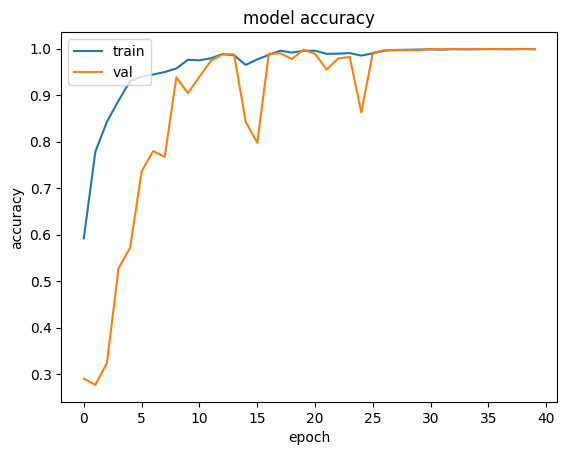

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

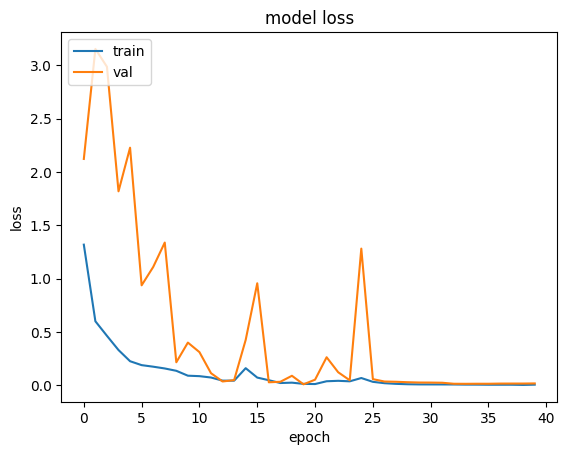

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [13]:
test_scores = model.evaluate(test_images)
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))
pred_labels = model.predict(test_images)

def roundoff(arr):
    """Hàm này chuyển giá trị lớn nhất trong mảng truyền vào = 1, các giá trị còn lại = 0"""
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

pred = np.argmax(pred_labels,axis=1)

print(classification_report(test_images.classes,pred,target_names=CLASSES))

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 1.0000 - loss: 0.0016
Testing Accuracy: 100.00%
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step
                 precision    recall  f1-score   support

Bacterialblight       1.00      1.00      1.00       159
          Blast       1.00      1.00      1.00       144
      Brownspot       1.00      1.00      1.00       160
         Tungro       1.00      1.00      1.00       131

       accuracy                           1.00       594
      macro avg       1.00      1.00      1.00       594
   weighted avg       1.00      1.00      1.00       594



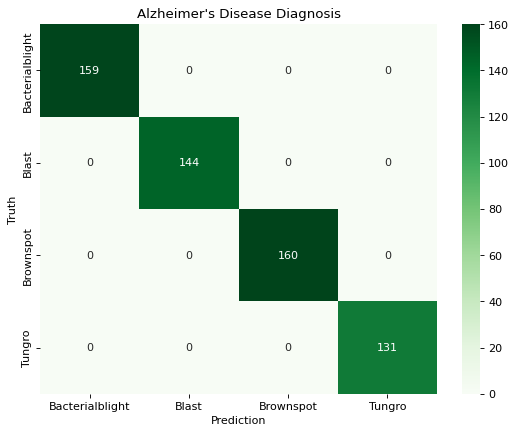

In [ ]:
# Plot the confusion matrix to understand the classification in detail
test_ls, pred_ls = test_images.classes,pred
conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES)

plt.title('Rice Leaf Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [15]:
#Printing some other classification metrics
print("Balanced Accuracy Score: {} %".format(round(BAS(test_ls, pred_ls) * 100, 2)))
print("Matthew's Correlation Coefficient: {} %".format(round(MCC(test_ls, pred_ls) * 100, 2)))

Balanced Accuracy Score: 100.0 %
Matthew's Correlation Coefficient: 100.0 %


In [16]:
model.save("Rice_leaf_disease_diagnosis (100%).h5")